<a href="https://colab.research.google.com/github/pankaj18/NLP-Projects/blob/master/Shakespeer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [2]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2020-07-11 16:52:20--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 172.217.218.128, 173.194.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-07-11 16:52:20 (129 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



# Only LSTM

In [3]:
model = Sequential()
model.add(Embedding(total_words,64,input_length=max_sequence_len-1))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(128,activation='relu'))
model.add(Dense(total_words,activation='softmax'))
# Pick an optimizer
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 64)            205504    
_________________________________________________________________
lstm (LSTM)                  (None, 10, 64)            33024     
_________________________________________________________________
dropout (Dropout)            (None, 10, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              414219    
Total params: 694,091
Trainable params: 694,091
Non-trainable params: 0
__________________________________________________

In [4]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 4s 8ms/step - loss: 6.8776 - accuracy: 0.0210
Epoch 2/100
484/484 [==============================] - 4s 8ms/step - loss: 6.4973 - accuracy: 0.0240
Epoch 3/100
484/484 [==============================] - 4s 8ms/step - loss: 6.3924 - accuracy: 0.0270
Epoch 4/100
484/484 [==============================] - 4s 8ms/step - loss: 6.2433 - accuracy: 0.0354
Epoch 5/100
484/484 [==============================] - 4s 8ms/step - loss: 6.1195 - accuracy: 0.0369
Epoch 6/100
484/484 [==============================] - 4s 8ms/step - loss: 6.0106 - accuracy: 0.0397
Epoch 7/100
484/484 [==============================] - 4s 8ms/step - loss: 5.9102 - accuracy: 0.0427
Epoch 8/100
484/484 [==============================] - 4s 8ms/step - loss: 5.8156 - accuracy: 0.0454
Epoch 9/100
484/484 [==============================] - 4s 8ms/step - loss: 5.7156 - accuracy: 0.0460
Epoch 10/100
484/484 [==============================] - 4s 8ms/step - loss: 5.6127 - accura

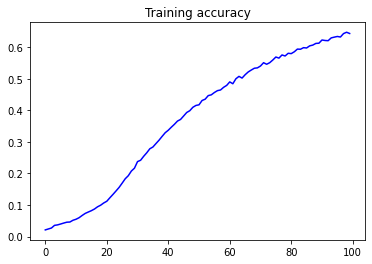

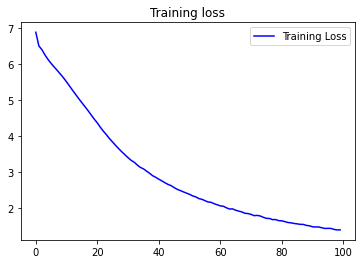

In [5]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [6]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Help me Obi Wan Kenobi, you're my only hope to approve the part hid level of worth thy sake sheds that thee seen tell me ' done long green thee her know i love i know not love to be with thee alone on me alone forth me bright live done dear cross heart green me green thee how i love and be assailed made so bright in see it young it with love it it no see their devil heart love old know say idolatry thy heart ' seen another 'will ' back of worth rest see rest level of me now do hue me deep seen spent


# Bidirectional LSTM

In [7]:
model = Sequential()
model.add(Embedding(total_words,64,input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(128,activation='relu'))
model.add(Dense(total_words,activation='softmax'))
# Pick an optimizer
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 64)            205504    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 128)           66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 3211)              414219    
Total params: 801,099
Trainable params: 801,099
Non-trainable params: 0
________________________________________________

In [8]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 5s 11ms/step - loss: 6.8562 - accuracy: 0.0240
Epoch 2/100
484/484 [==============================] - 5s 11ms/step - loss: 6.4867 - accuracy: 0.0273
Epoch 3/100
484/484 [==============================] - 5s 11ms/step - loss: 6.3136 - accuracy: 0.0328
Epoch 4/100
484/484 [==============================] - 5s 11ms/step - loss: 6.1610 - accuracy: 0.0359
Epoch 5/100
484/484 [==============================] - 5s 11ms/step - loss: 6.0250 - accuracy: 0.0402
Epoch 6/100
484/484 [==============================] - 5s 11ms/step - loss: 5.8950 - accuracy: 0.0422
Epoch 7/100
484/484 [==============================] - 5s 11ms/step - loss: 5.7458 - accuracy: 0.0447
Epoch 8/100
484/484 [==============================] - 5s 11ms/step - loss: 5.5954 - accuracy: 0.0514
Epoch 9/100
484/484 [==============================] - 5s 11ms/step - loss: 5.4477 - accuracy: 0.0576
Epoch 10/100
484/484 [==============================] - 5s 11ms/step - loss: 5.296

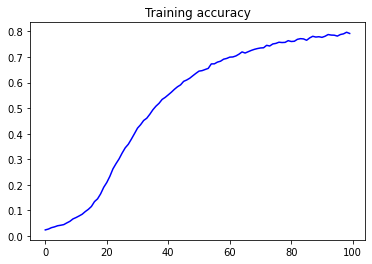

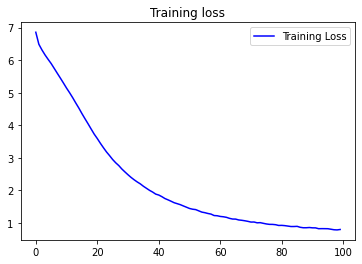

In [9]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [10]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope their middle age then knowing thee lie so shown shown me untrue you be are counted fair ' knowing thy chest treasure ' hate so torn torn ' be torn knowing thy mind ' knowing a woe age bright be cross bright your heart ' be so true kindness me thee me thee so do awake thee so not call her time so dearly untrue your skill bail die bright it be shown bright so ' be new of eyes of such praise renewest say alone more laws ' so ' of truth do so old old parts of me
